# Prepare time-series data from ALOS-2 imagery

In [1]:
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio.mask
from scipy.ndimage import uniform_filter

## Load the ALOS-2 image

In [64]:
# Load the ALOS-2 image
image_path = '/home/jovyan/shared/PCN/ALOS-2/ALOS-2 data/Alos_2_2015_HV.tif'

# Load the AOI shapefile
aoi = gpd.read_file('/home/jovyan/shared/PCN/ALOS-2/ALOS-2 data/AOI_shapefile.shp')

## Visualize the original full image

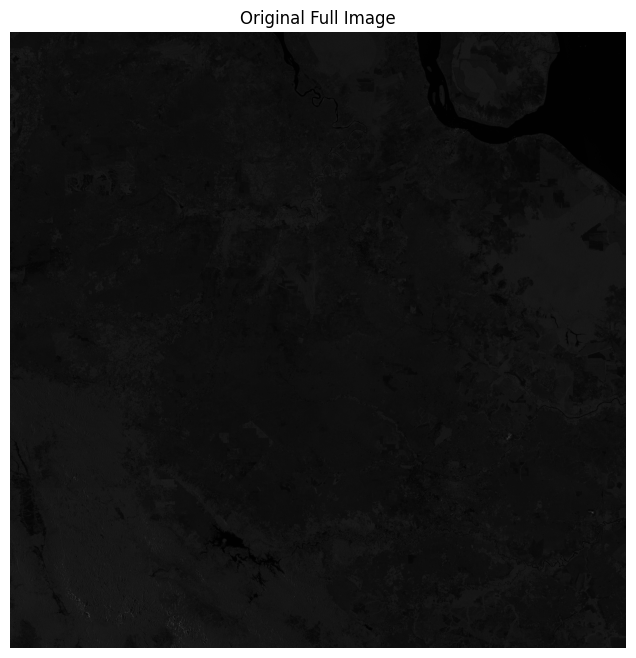

In [65]:
# Step to visualize the original full image
with rasterio.open(image_path) as src:
    original_image = src.read(1)  # Read the first band for visualization

def visualize_original(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.title('Original Full Image')
    plt.axis('off')
    plt.show()

# Visualize the original full image
visualize_original(original_image)

## Clip the image to the AOI using a shapefile

This step clips the image based on the provided AOI shapefile.

In [66]:
# Clip the image to the AOI
with rasterio.open(image_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, aoi.geometry, crop=True)
    out_meta = src.meta.copy()

# Update metadata
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save the clipped image
#with rasterio.open('path_to_output_image.tif', 'w', **out_meta) as dest:
#    dest.write(out_image)

## Apply the calibration expression

After clipping, the calibration formula is applied to the clipped image.

In [67]:
# Apply the calibration formula to the clipped image
clipped_image = out_image[0]  # Take the first band of the clipped image
calibrated_image = (20 * np.log10(clipped_image)) - 83

## Use a Lee filter to reduce speckle

Speckle reduction using the Lee filter is performed on the calibrated image.

This code applies a lee filter to the two SAR images (image1 and image2) to reduce speckle noise. Speckle is a common issue in SAR images, it helps smooth the image by averaging pixel values in a local neighborhood.

In [68]:
# Apply Lee filter to the calibrated image
def lee_filter(image, size=5):
    # Mean filter
    mean = uniform_filter(image, (size, size))
    # Mean of squares
    mean_sq = uniform_filter(image**2, (size, size))
    # Variance
    variance = mean_sq - mean**2
    
    # Coefficient of variation
    overall_variance = np.var(image)
    noise_variance = np.maximum(variance - overall_variance, 0)

    # Lee filter
    weights = noise_variance / (noise_variance + variance)
    filtered_image = mean + weights * (image - mean)
    
    return filtered_image

# Apply the Lee filter
filtered_image = lee_filter(calibrated_image)

## Visualize original clipped, calibrated, and filtered images

The original clipped image, calibrated image, and filtered image are visualized side by side.

In [69]:
# Visualize original clipped, calibrated, and filtered images
def visualize_images(original, calibrated, filtered):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Original Clipped Image
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title('Clipped Image')
    axs[0].axis('off')

    # Calibrated Image
    axs[1].imshow(calibrated, cmap='gray')
    axs[1].set_title('Calibrated Image')
    axs[1].axis('off')

    # Filtered Image
    axs[2].imshow(filtered, cmap='gray')
    axs[2].set_title('Filtered Image (Lee Filter)')
    axs[2].axis('off')

    plt.show()


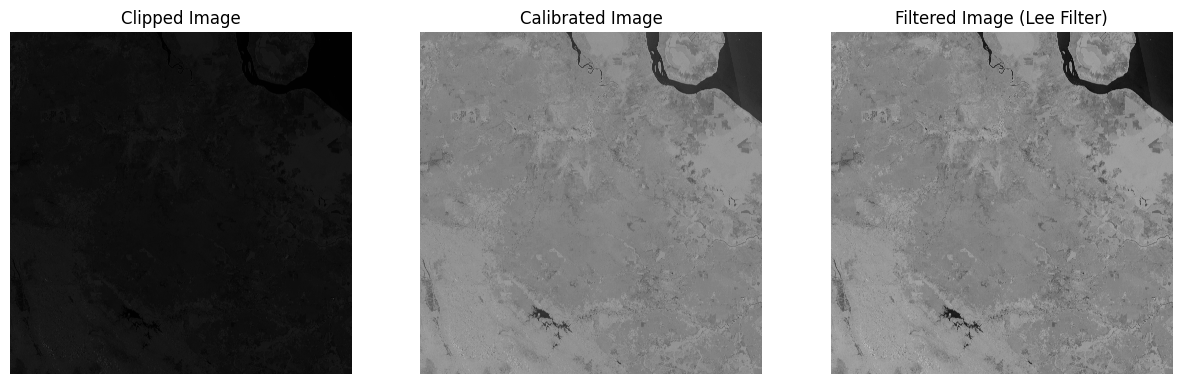

In [70]:
# Visualize the clipped, calibrated, and filtered images
visualize_images(clipped_image, calibrated_image, filtered_image)

## Save the image

In [71]:
with rasterio.open('2015HVclipped5_image.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

# Update metadata for calibrated and filtered images (since their values have changed)
calibrated_meta = out_meta.copy()
calibrated_meta.update({
    "dtype": 'float32',  # Ensure proper data type for calibrated values
})

# Save the calibrated image
with rasterio.open('2015HVcalibrated5_image.tif', 'w', **calibrated_meta) as dest:
    dest.write(calibrated_image, 1)  # Write the calibrated image to band 1

# Save the filtered image
with rasterio.open('2015HVfiltered5_image.tif', 'w', **calibrated_meta) as dest:
    dest.write(filtered_image, 1)  # Write the filtered image to band 1
